## House Price Prediction
### Michał Lange
####  Data exploration and machine learning in scientific research


The following python notebook will train an ML model based to predict House prices based off of data from the following kaggle competition: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques. This document will delineate each step of the pipeline as well as showing the associated python code and results.

1.) The first step is to import all necessary python packages.

In [1]:
import pandas as pd
import plotly.express as px

Now let's import our data and take a look at the column values to see what we are working with.

In [2]:
train_path = "./data/train.csv"
test_path = "./data/test.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# Display the parameters of the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In total we have 79 total features we can use for prediction, however we should drop "Id" from both datasets as it is just a building indicator and has no predictive capabilities.

In [3]:
train = train.drop('Id', axis=1)
test = test.drop('Id', axis=1)

## Exploratory Data Analysis

Let's check for missing values in our dataset to understand what data cleaning will be required.

Number of features with missing values: 19


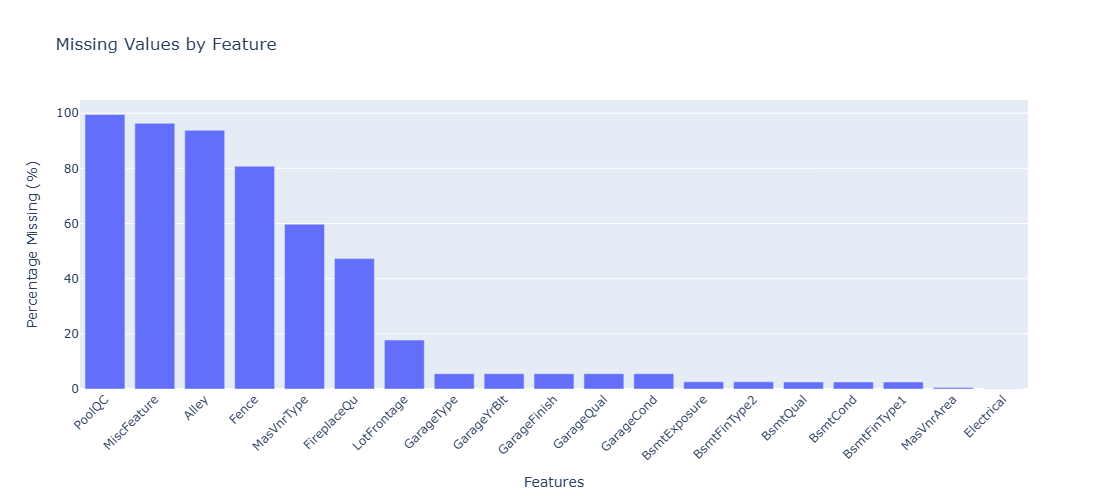

In [4]:
# Check for missing values in training data
missing_train = train.isnull().sum()
missing_train = missing_train[missing_train > 0].sort_values(ascending=False)

# Calculate percentage of missing values
missing_percent = (missing_train / len(train)) * 100

print(f"Number of features with missing values: {len(missing_train)}")

# Create bar chart visualization
fig = px.bar(
    x=missing_percent.index,
    y=missing_percent.values,
    labels={'x': 'Features', 'y': 'Percentage Missing (%)'},
    title='Missing Values by Feature'
)

fig.update_layout(
    xaxis_tickangle=-45,
    height=500,
    showlegend=False
)

fig.show()

There are several things here of note but let's address them one by one. In the case of MasVnrArea and Electrical the missing percentage is low enough that we can impute the missing values with the median for numerical and mode for categorical.

In [5]:
# Impute MasVnrArea and Electrical with median/mode
train['MasVnrArea'] = train['MasVnrArea'].fillna(train['MasVnrArea'].median())
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

# Do the same for test set
test['MasVnrArea'] = test['MasVnrArea'].fillna(test['MasVnrArea'].median())
test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode()[0])

Now we can see we have very similar groups of features that start with "Bsmt" and "Garage". This most likely indicates a group of houses that have missing basements or garages. To test this theory we can first check if those features are missing in the same rows.

In [6]:
# Get all basement and garage features
bsmt_features = [col for col in train.columns if col.startswith('Bsmt')]
garage_features = [col for col in train.columns if col.startswith('Garage')]

print(f"Basement features: {bsmt_features}")
print(f"Garage features: {garage_features}")

# Check if missing values occur in the same rows for basement features
bsmt_missing_together = train[bsmt_features].isnull().sum(axis=1)
print(f"\nHouses with ALL basement features missing: {(bsmt_missing_together == len(bsmt_features)).sum()}")
print(f"Houses with SOME basement features missing: {((bsmt_missing_together > 0) & (bsmt_missing_together < len(bsmt_features))).sum()}")

# Check if missing values occur in the same rows for garage features
garage_missing_together = train[garage_features].isnull().sum(axis=1)
print(f"\nHouses with ALL garage features missing: {(garage_missing_together == len(garage_features)).sum()}")
print(f"Houses with SOME garage features missing: {((garage_missing_together > 0) & (garage_missing_together < len(garage_features))).sum()}")

Basement features: ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath']
Garage features: ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']

Houses with ALL basement features missing: 0
Houses with SOME basement features missing: 39

Houses with ALL garage features missing: 0
Houses with SOME garage features missing: 81


We can see there are some houses with partial basement data missing. Let's visualize which specific basement features are missing across these houses using a heatmap.

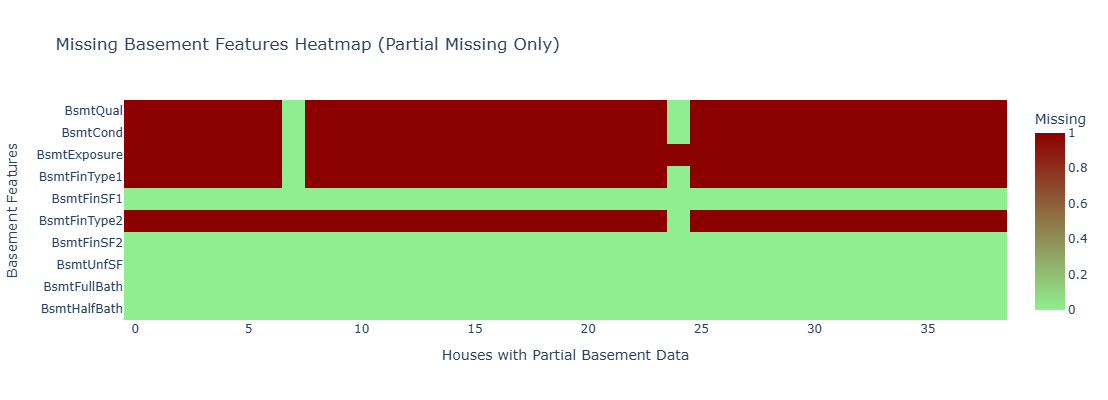

In [7]:
# Get houses with partial basement data missing
partial_bsmt_missing = (bsmt_missing_together > 0) & (bsmt_missing_together < len(bsmt_features))
partial_bsmt_houses = train[partial_bsmt_missing]

# Create a heatmap showing which basement features are missing
missing_matrix = partial_bsmt_houses[bsmt_features].isnull().astype(int)

# Reset index to show house numbers instead of IDs
missing_matrix_reset = missing_matrix.reset_index(drop=True)

fig = px.imshow(
    missing_matrix_reset.T,
    labels=dict(x="House Number", y="Basement Features", color="Missing"),
    y=bsmt_features,
    color_continuous_scale=['lightgreen', 'darkred'],
    title='Missing Basement Features Heatmap (Partial Missing Only)'
)

fig.update_layout(
    height=400,
    xaxis_title="Houses with Partial Basement Data",
    yaxis_title="Basement Features"
)

fig.show()


Since some houses have only partial basement data missing rather than all basement features missing together, this suggests the missingness is not simply due to absence of a basement. The missing values may reflect incomplete data collection during the appraisal process. Rather than imputing with mode, which could introduce bias, we'll create a new "Missing" category to preserve this information.

In [8]:
# Fill missing basement features with "Missing" category for categorical, 0 for numerical
for feature in bsmt_features:
    if train[feature].dtype == 'object':
        train[feature] = train[feature].fillna('Missing')
        test[feature] = test[feature].fillna('Missing')
    else:
        train[feature] = train[feature].fillna(0)
        test[feature] = test[feature].fillna(0)

Let's take a look now at the Garage features to see if we have the same issue.

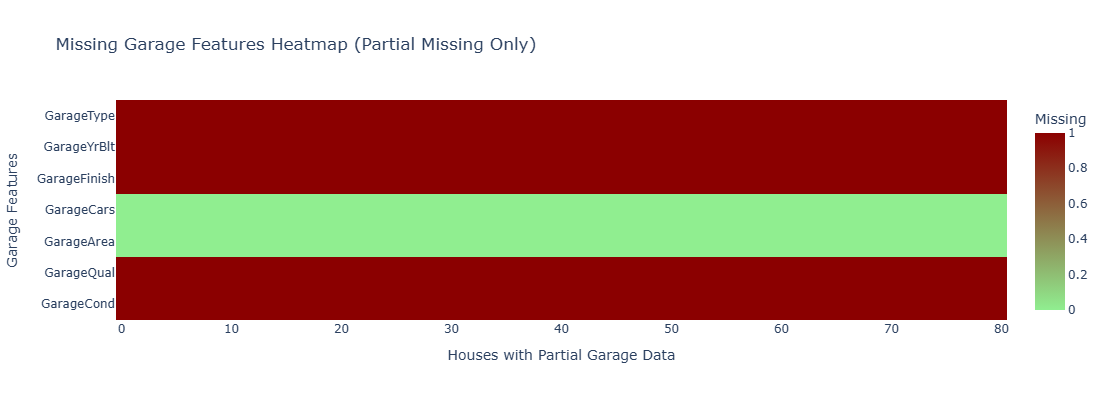

In [9]:
# Get houses with partial garage data missing
partial_garage_missing = (garage_missing_together > 0) & (garage_missing_together < len(garage_features))
partial_garage_houses = train[partial_garage_missing]

# Create a heatmap showing which garage features are missing
missing_matrix = partial_garage_houses[garage_features].isnull().astype(int)

# Reset index to show house numbers instead of IDs
missing_matrix_reset = missing_matrix.reset_index(drop=True)

fig = px.imshow(
    missing_matrix_reset.T,
    labels=dict(x="House Number", y="Garage Features", color="Missing"),
    y=garage_features,
    color_continuous_scale=['lightgreen', 'darkred'],
    title='Missing Garage Features Heatmap (Partial Missing Only)'
)

fig.update_layout(
    height=400,
    xaxis_title="Houses with Partial Garage Data",
    yaxis_title="Garage Features"
)

fig.show()

Same thing as with the basement situation, for some reason it was not included in the appraisal process therefore we will also populate both test and training set, with an additional missing feature.

In [10]:
# Fill missing garage features with "Missing" category for categorical, 0 for numerical
for feature in garage_features:
    if train[feature].dtype == 'object':
        train[feature] = train[feature].fillna('Missing')
        test[feature] = test[feature].fillna('Missing')        
    else:
        train[feature] = train[feature].fillna(0)
        test[feature] = test[feature].fillna(0)

The next to check is LotFrontage with nearly 20% missing values from the dataset. Let us first plot the results to get a better overview of the data.

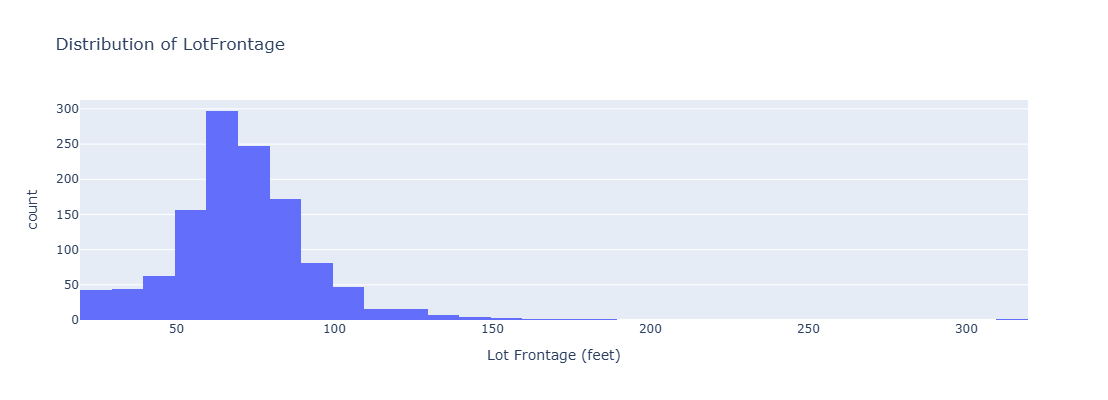

In [11]:
# Plot LotFrontage distribution
fig = px.histogram(
    train,
    x='LotFrontage',
    nbins=50,
    title='Distribution of LotFrontage',
    labels={'LotFrontage': 'Lot Frontage (feet)', 'count': 'Frequency'}
)

fig.update_layout(
    showlegend=False,
    height=400
)

fig.show()

The distribution seems fairly normal in the mathematical s

Let's investigate if the missingness of LotFrontage is related to other lot-related features by comparing distributions between houses with and without LotFrontage data.

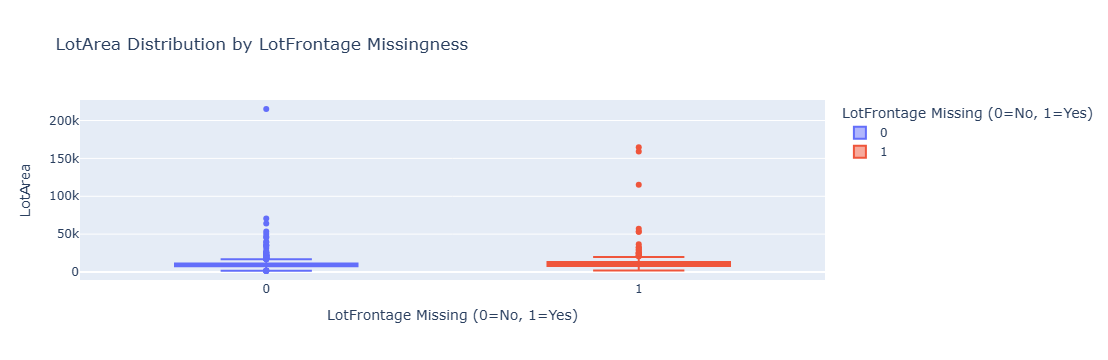

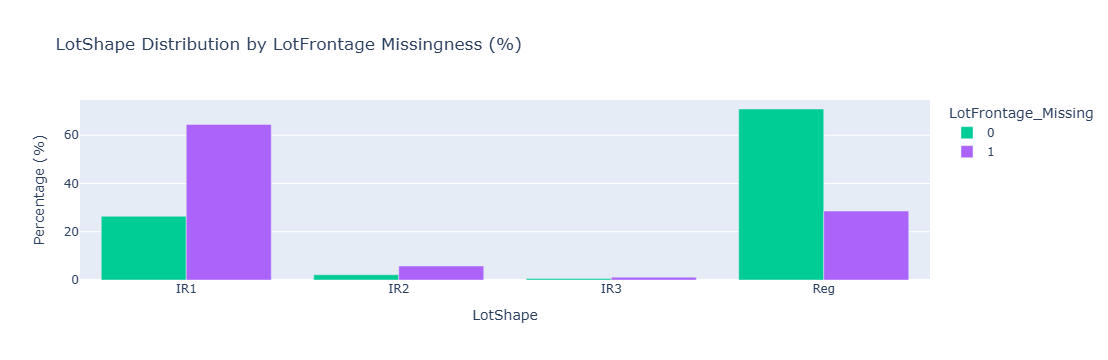

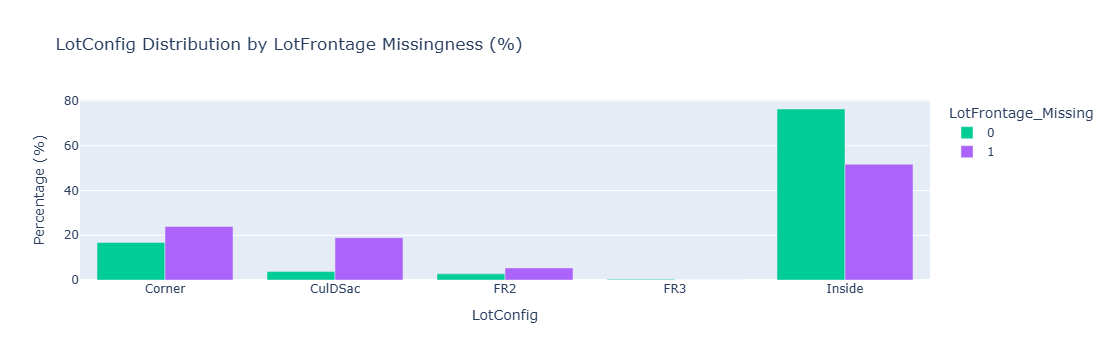

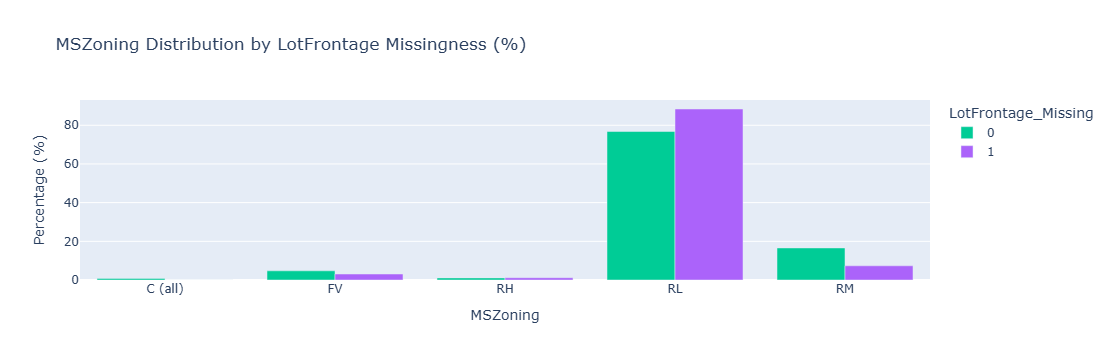

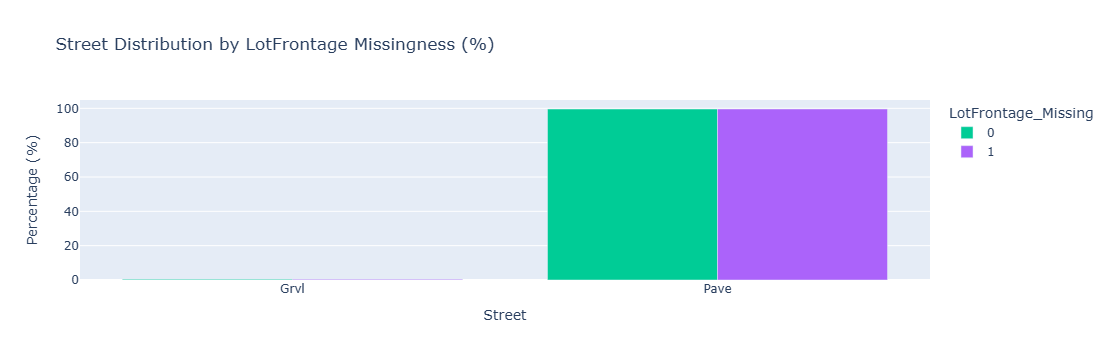

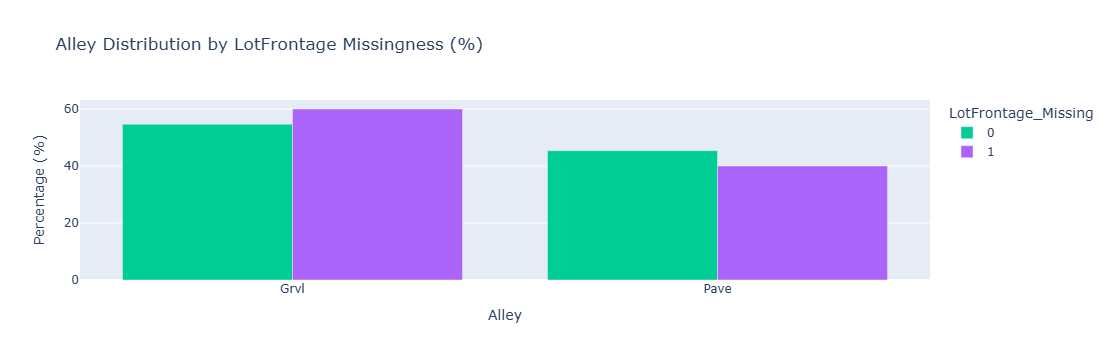

In [12]:
# Create a missingness indicator
train['LotFrontage_Missing'] = train['LotFrontage'].isnull().astype(int)

# Compare lot-related features
lot_features = ['LotArea', 'LotShape', 'LotConfig', 'MSZoning', 'Street', 'Alley']

# Visualize numerical features with box plots
numerical_features = [f for f in lot_features if train[f].dtype in ['int64', 'float64']]
if numerical_features:
    for feature in numerical_features:
        fig = px.box(
            train,
            x='LotFrontage_Missing',
            y=feature,
            title=f'{feature} Distribution by LotFrontage Missingness',
            labels={'LotFrontage_Missing': 'LotFrontage Missing (0=No, 1=Yes)'},
            color='LotFrontage_Missing'
        )
        fig.show()

# Visualize categorical features with grouped bar charts
categorical_features = [f for f in lot_features if train[f].dtype == 'object']
for feature in categorical_features:
    # Create crosstab with percentages
    crosstab = pd.crosstab(train[feature], train['LotFrontage_Missing'], normalize='columns') * 100
    
    fig = px.bar(
        crosstab,
        barmode='group',
        title=f'{feature} Distribution by LotFrontage Missingness (%)',
        labels={'value': 'Percentage (%)', 'variable': 'LotFrontage Missing'},
        color_discrete_map={0: 'lightblue', 1: 'coral'}
    )
    fig.update_layout(xaxis_title=feature)
    fig.show()

As we can see from the generated plots, we can't correlate the fact that the data is missing to any particular semantically related feature. Therefore we will fill in the missing values using neighborhood-based median imputation, which accounts for the fact that houses in the same neighborhood likely have similar lot frontages.

Before we impute based on neighborhood, let's verify that LotFrontage does indeed vary significantly by neighborhood.

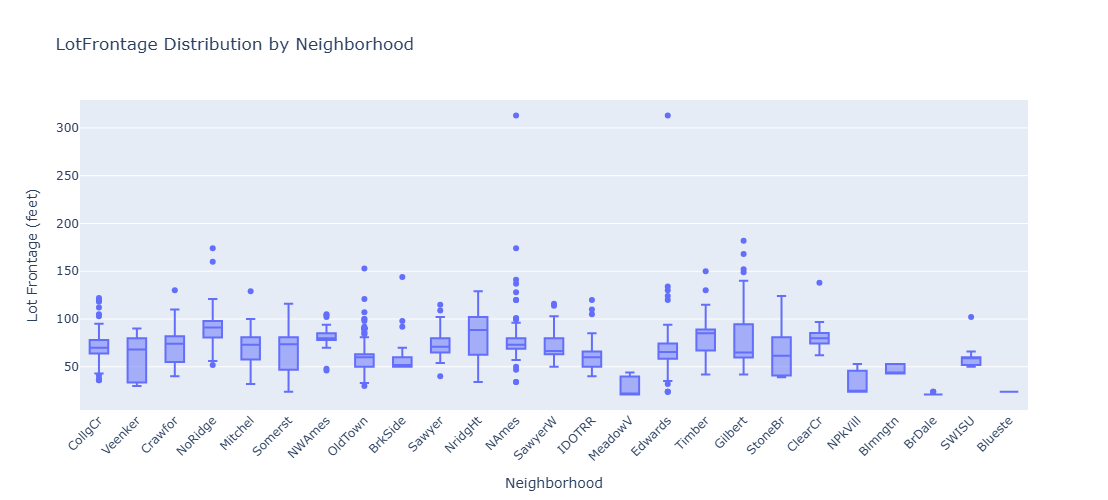

In [13]:
# Visualize LotFrontage distribution by Neighborhood
fig = px.box(
    train,
    x='Neighborhood',
    y='LotFrontage',
    title='LotFrontage Distribution by Neighborhood',
    labels={'LotFrontage': 'Lot Frontage (feet)', 'Neighborhood': 'Neighborhood'}
)

fig.update_layout(
    xaxis_tickangle=-45,
    height=500,
    showlegend=False
)

fig.show()

From the above we can see some variation in the distribution between neighborhoods, hence the choice for imputation by neighborhood.

In [14]:
# Impute LotFrontage based on neighborhood median

# Calculate neighborhood medians from training data
neighborhood_medians = train.groupby('Neighborhood')['LotFrontage'].median()

# Impute train set
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

# Impute test set using training set medians
test['LotFrontage'] = test.apply(
    lambda row: neighborhood_medians.get(row['Neighborhood'], train['LotFrontage'].median()) 
    if pd.isna(row['LotFrontage']) else row['LotFrontage'],
    axis=1
)

# Handle any remaining missing values with global training median
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].median())
test['LotFrontage'] = test['LotFrontage'].fillna(train['LotFrontage'].median())

# Drop the temporary LotFrontage_Missing indicator column
train = train.drop('LotFrontage_Missing', axis=1)

Now let's remove the remaining features with high missing percentages (higher than LotFrontage's ~20%). These features would require extensive imputation and may not provide enough predictive value to justify keeping them.

In [15]:
# Identify features with more than 20% missing values
missing_threshold = 0.20
high_missing = (train.isnull().sum() / len(train)) > missing_threshold

# Get list of features to drop
features_to_drop = high_missing[high_missing].index.tolist()

print(f"Features to drop (>{missing_threshold*100}% missing): {features_to_drop}")
print(f"Total features to drop: {len(features_to_drop)}")

# Drop these features from both train and test sets
train = train.drop(columns=features_to_drop)
test = test.drop(columns=features_to_drop)

print(f"\nRemaining features in train: {train.shape[1]}")
print(f"Remaining features in test: {test.shape[1]}")

Features to drop (>20.0% missing): ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
Total features to drop: 6

Remaining features in train: 74
Remaining features in test: 73


In [16]:
# Final check for any remaining missing values
print("Missing values in train set:")
print(train.isnull().sum().sum())

print("\nMissing values in test set:")
print(test.isnull().sum().sum())

Missing values in train set:
0

Missing values in test set:
13


In [17]:
# Check which features have missing values in test set
test_missing = test.isnull().sum()
test_missing = test_missing[test_missing > 0].sort_values(ascending=False)

print("Features with missing values in test set:")
print(test_missing)

Features with missing values in test set:
MSZoning       4
Utilities      2
Functional     2
Exterior1st    1
Exterior2nd    1
TotalBsmtSF    1
KitchenQual    1
SaleType       1
dtype: int64


In [18]:
# Impute remaining missing values in test set
for col in test_missing.index:
    if test[col].dtype == 'object':
        # Categorical: use mode from training data
        test[col] = test[col].fillna(train[col].mode()[0])
    else:
        # Numerical: use median from training data
        test[col] = test[col].fillna(train[col].median())

# Verify all missing values are handled
print(f"Missing values in test set after imputation: {test.isnull().sum().sum()}")

Missing values in test set after imputation: 0


## Target Variable Analysis

Now let's analyze the distribution of our target variable, SalePrice, to understand its characteristics.

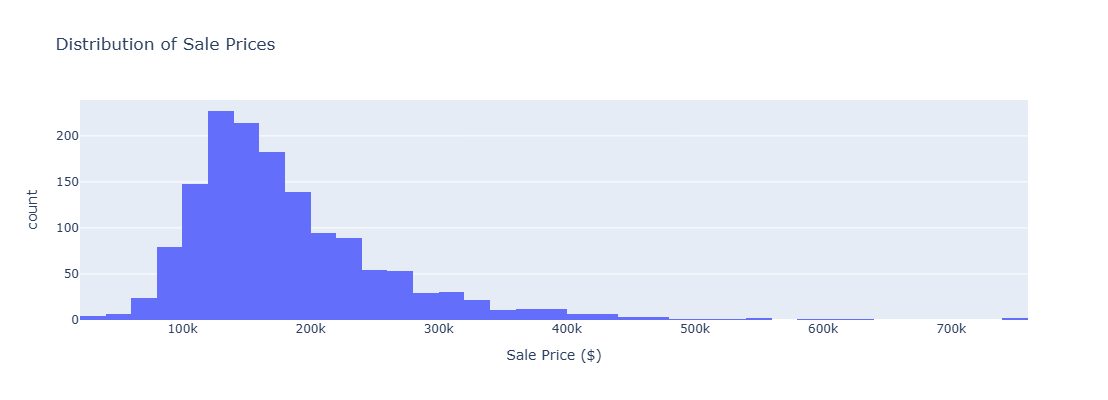


Sale Price Summary Statistics:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [19]:
# Visualize SalePrice distribution
fig = px.histogram(
    train,
    x='SalePrice',
    nbins=50,
    title='Distribution of Sale Prices',
    labels={'SalePrice': 'Sale Price ($)', 'count': 'Frequency'}
)

fig.update_layout(
    showlegend=False,
    height=400
)

fig.show()

# Display summary statistics
print("\nSale Price Summary Statistics:")
print(train['SalePrice'].describe())

The distribution shows right-skewness with some high-value outliers (max $755k vs median $163k). Let's check the skewness and visualize with a box plot to better identify outliers.

Skewness: 1.883
(Values > 1 indicate significant right skew)


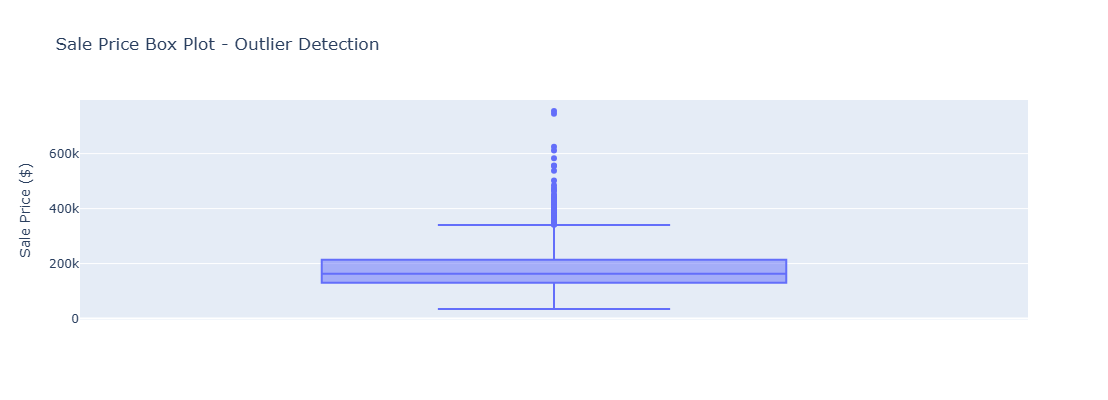


Number of outliers (IQR method): 61


In [20]:
import numpy as np
from scipy import stats

# Calculate skewness
skewness = train['SalePrice'].skew()
print(f"Skewness: {skewness:.3f}")
print("(Values > 1 indicate significant right skew)")

# Box plot to visualize outliers
fig = px.box(
    train,
    y='SalePrice',
    title='Sale Price Box Plot - Outlier Detection',
    labels={'SalePrice': 'Sale Price ($)'}
)

fig.update_layout(height=400)
fig.show()

# Count outliers using IQR method
Q1 = train['SalePrice'].quantile(0.25)
Q3 = train['SalePrice'].quantile(0.75)
IQR = Q3 - Q1
outliers = train[(train['SalePrice'] < Q1 - 1.5 * IQR) | (train['SalePrice'] > Q3 + 1.5 * IQR)]
print(f"\nNumber of outliers (IQR method): {len(outliers)}")

With a skewness of 1.883, the distribution is significantly right-skewed. Applying a log transformation will normalize the distribution, which typically improves model performance for regression tasks.

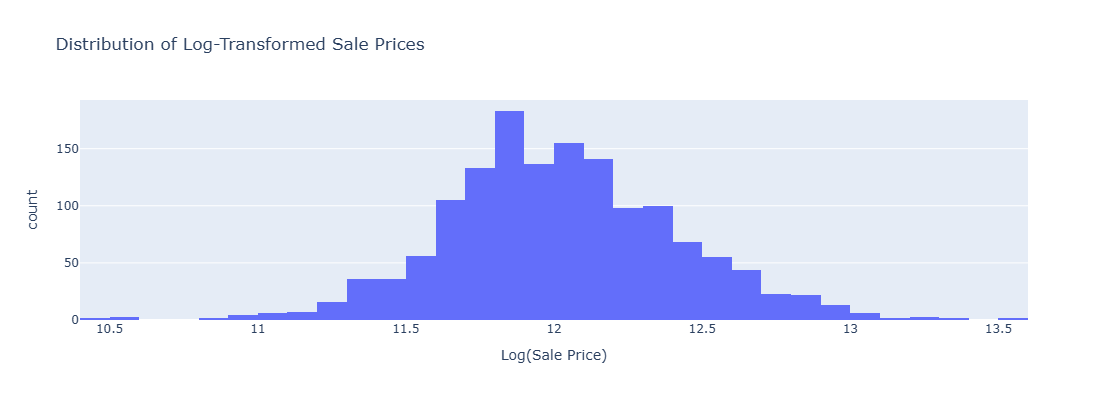

Skewness after log transformation: 0.121


In [21]:
# Apply log transformation to SalePrice
train['SalePrice_Log'] = np.log1p(train['SalePrice'])

# Visualize transformed distribution
fig = px.histogram(
    train,
    x='SalePrice_Log',
    nbins=50,
    title='Distribution of Log-Transformed Sale Prices',
    labels={'SalePrice_Log': 'Log(Sale Price)', 'count': 'Frequency'}
)

fig.update_layout(showlegend=False, height=400)
fig.show()

# Check new skewness
new_skewness = train['SalePrice_Log'].skew()
print(f"Skewness after log transformation: {new_skewness:.3f}")

The log transformation reduced skewness from 1.883 to 0.121, making the distribution nearly normal. This will help our regression models perform better and meet their assumptions about normally distributed residuals. We'll use `SalePrice_Log` as our target variable for modeling and convert predictions back using exponential transformation.

## Feature Encoding and Scaling

Now we'll encode categorical variables (using ordinal encoding for ordered categories and one-hot encoding for nominal categories) and standardize numerical features to mean 0 and standard deviation 1.

In [22]:
# Define ordinal features with their proper ordering based on data_description.txt
ordinal_mappings = {
    'LotShape': {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1, 'Missing': 0},
    'LandSlope': {'Gtl': 3, 'Mod': 2, 'Sev': 1, 'Missing': 0},
    'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Missing': 0},
    'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Missing': 0},
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Missing': 0},
    'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Missing': 0},
    'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'Missing': 0},
    'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'Missing': 0},
    'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'Missing': 0},
    'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Missing': 0},
    'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Missing': 0},
    'Functional': {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1, 'Missing': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'Missing': 0},
    'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Missing': 0},
    'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Missing': 0},
    'PavedDrive': {'Y': 3, 'P': 2, 'N': 1, 'Missing': 0},
    'Street': {'Pave': 2, 'Grvl': 1, 'Missing': 0},
    'CentralAir': {'Y': 1, 'N': 0, 'Missing': 0}
}

# Apply ordinal encoding
for col, mapping in ordinal_mappings.items():
    if col in train.columns:
        train[col] = train[col].map(mapping)
        test[col] = test[col].map(mapping)

print(f"Encoded {len(ordinal_mappings)} ordinal features")

Encoded 18 ordinal features


In [23]:
# Identify remaining categorical (nominal) features for one-hot encoding
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()

# Remove SalePrice if it's there (shouldn't be since it's numeric)
if 'SalePrice' in categorical_cols:
    categorical_cols.remove('SalePrice')

print(f"Nominal categorical features to one-hot encode: {len(categorical_cols)}")
print(categorical_cols[:10])  # Show first 10

# One-hot encode nominal categorical variables
train_encoded = pd.get_dummies(train, columns=categorical_cols, drop_first=True)
test_encoded = pd.get_dummies(test, columns=categorical_cols, drop_first=True)

# Align columns between train and test sets
train_encoded, test_encoded = train_encoded.align(test_encoded, join='left', axis=1, fill_value=0)

print(f"\nFeatures after encoding: {train_encoded.shape[1]}")

Nominal categorical features to one-hot encode: 19
['MSZoning', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle']

Features after encoding: 192


In [37]:
# Separate features and target variable
X = train_encoded.drop(['SalePrice', 'SalePrice_Log'], axis=1)
y = train_encoded['SalePrice_Log']

# Remove SalePrice columns from test set if they exist (from alignment)
X_test = test_encoded.drop(['SalePrice', 'SalePrice_Log'], axis=1, errors='ignore')

# Identify numerical features for scaling (excluding binary encoded features)
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Total features: {len(X.columns)}")
print(f"Numerical features to scale: {len(numerical_features)}")

Total features: 190
Numerical features to scale: 54


In [38]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Convert any remaining 'Missing' strings to 0 (safety check)
for col in numerical_features:
    if X[col].dtype == 'object':
        X[col] = X[col].replace('Missing', 0).astype(float)
    if X_test[col].dtype == 'object':
        X_test[col] = X_test[col].replace('Missing', 0).astype(float)

# Fit on training data and transform both train and test
X[numerical_features] = scaler.fit_transform(X[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print("Numerical features standardized to mean=0, std=1")
print(f"\nFinal dataset shapes:")
print(f"X_train: {X.shape}")
print(f"y_train: {y.shape}")
print(f"X_test: {X_test.shape}")

Numerical features standardized to mean=0, std=1

Final dataset shapes:
X_train: (1460, 190)
y_train: (1460,)
X_test: (1459, 190)


In [39]:
from sklearn.model_selection import train_test_split

# Split into training (90%) and validation (10%) sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nData is ready for modeling!")

Training set: 1314 samples
Validation set: 146 samples
Test set: 1459 samples

Data is ready for modeling!


## Model Training and Evaluation

We'll train three different models to predict house prices: Random Forest, XGBoost, and a Neural Network. Each will be evaluated on the validation set.

### 1. Random Forest Regressor

In [34]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

rf_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

print("Running Grid Search for Random Forest...")
rf_grid = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=-1,
)

rf_grid.fit(X_train, y_train)

best_params = rf_grid.best_params_
best_cv_rmse_log = np.sqrt(-rf_grid.best_score_)  # RMSE on the same scale as y_train

print(f"\nBest parameters: {best_params}")
print(f"Best CV score (RMSE on y scale): {best_cv_rmse_log:.4f}")

# Best model
rf_model = rf_grid.best_estimator_

# Predict on validation (still on log scale if y was log1p)
y_val_pred_rf_log = rf_model.predict(X_val)

# Convert to original scale
y_val_actual = np.expm1(y_val)
y_val_pred_rf = np.expm1(y_val_pred_rf_log)

# Metrics on original scale
rmse_rf = np.sqrt(mean_squared_error(y_val_actual, y_val_pred_rf))
mae_rf = mean_absolute_error(y_val_actual, y_val_pred_rf)
r2_rf = r2_score(y_val_actual, y_val_pred_rf)

print("\nRandom Forest Performance (Validation Set, original scale):")
print(f"R² Score: {r2_rf:.4f}")
print(f"MAE:  ${mae_rf:,.2f}")
print(f"RMSE: ${rmse_rf:,.2f}")



Running Grid Search for Random Forest...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score (RMSE on y scale): 0.1473

Random Forest Performance (Validation Set, original scale):
R² Score: 0.8886
MAE:  $16,564.36
RMSE: $31,900.03


### 2. XGBoost Regressor

In [28]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define parameter grid for XGBoost
xgb_param_grid = {
    "n_estimators": [500, 1000, 1500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 5, 6],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
}

# Initialize XGBoost
xgb_base = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1,
    objective="reg:squarederror",
)

print("Running Grid Search for XGBoost...")
xgb_grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=xgb_param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=-1,
)

xgb_grid.fit(X_train, y_train)

best_params = xgb_grid.best_params_
best_cv_rmse_log = np.sqrt(-xgb_grid.best_score_)  # RMSE on the same scale as y_train

print(f"\nBest parameters: {best_params}")
print(f"Best CV score (RMSE on y scale): {best_cv_rmse_log:.4f}")

# Use best model
xgb_model = xgb_grid.best_estimator_

# Predict on validation (log scale if y was log1p)
y_val_pred_xgb_log = xgb_model.predict(X_val)

# Convert to original scale
y_val_actual = np.expm1(y_val)
y_val_pred_xgb = np.expm1(y_val_pred_xgb_log)

# Metrics on original scale
rmse_xgb = np.sqrt(mean_squared_error(y_val_actual, y_val_pred_xgb))
mae_xgb = mean_absolute_error(y_val_actual, y_val_pred_xgb)
r2_xgb = r2_score(y_val_actual, y_val_pred_xgb)

print("\nXGBoost Performance (Validation Set, original scale):")
print(f"R² Score: {r2_xgb:.4f}")
print(f"MAE:  ${mae_xgb:,.2f}")
print(f"RMSE: ${rmse_xgb:,.2f}")


Running Grid Search for XGBoost...
Fitting 3 folds for each of 972 candidates, totalling 2916 fits

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 1500, 'subsample': 0.7}
Best CV score (RMSE on y scale): 0.1316

XGBoost Performance (Validation Set, original scale):
R² Score: 0.9143
MAE:  $14,081.73
RMSE: $27,987.33


### 3. Neural Network

In [31]:
from tensorflow import keras
from tensorflow.keras import layers

# If y is log1p(target), define actual values for metrics
y_val_actual = np.expm1(y_val)

# Build Neural Network architecture
nn_model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu"),
    # Enforce non-negative prediction on log scale (recommended for log1p targets)
    layers.Dense(1, activation="relu"),
])

# Compile model
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae"],
)

print("Training Neural Network...")
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True
        )
    ],
)

# Predict on validation (log scale)
y_val_pred_nn_log = nn_model.predict(X_val, verbose=0).reshape(-1)

# Convert predictions back to original scale
y_val_pred_nn = np.expm1(y_val_pred_nn_log)

# Compute metrics on original scale
rmse_nn = np.sqrt(mean_squared_error(y_val_actual, y_val_pred_nn))
mae_nn = mean_absolute_error(y_val_actual, y_val_pred_nn)
r2_nn = r2_score(y_val_actual, y_val_pred_nn)

print("\nNeural Network Performance (Validation Set, original scale):")
print(f"RMSE: ${rmse_nn:,.2f}")
print(f"MAE:  ${mae_nn:,.2f}")
print(f"R² Score: {r2_nn:.4f}")


Training Neural Network...

Neural Network Performance (Validation Set, original scale):
RMSE: $93,485.38
MAE:  $74,999.03
R² Score: 0.0435


### Model Comparison

Model Performance Comparison:
         Model     RMSE ($)      MAE ($)  R² Score
       XGBoost 27987.331105 14081.734857  0.914269
 Random Forest 31900.030025 16564.361973  0.888623
Neural Network 93485.381888 74999.025785  0.043465


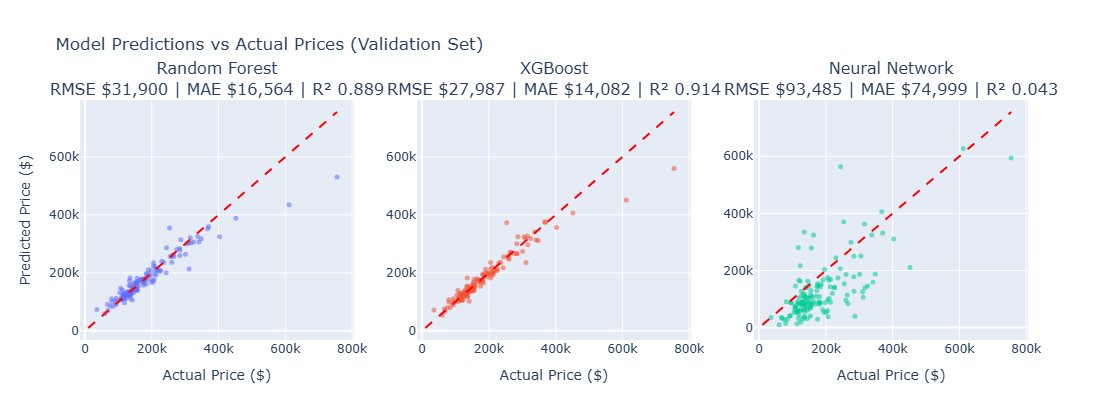

In [35]:
import numpy as np
import pandas as pd

# --- Ensure arrays are clean and aligned ---
y_true = np.asarray(y_val_actual).reshape(-1)
y_rf   = np.asarray(y_val_pred_rf).reshape(-1)
y_xgb  = np.asarray(y_val_pred_xgb).reshape(-1)
y_nn   = np.asarray(y_val_pred_nn).reshape(-1)

# Keep only rows where all values are finite (prevents plot/metric issues)
mask = np.isfinite(y_true) & np.isfinite(y_rf) & np.isfinite(y_xgb) & np.isfinite(y_nn)
y_true, y_rf, y_xgb, y_nn = y_true[mask], y_rf[mask], y_xgb[mask], y_nn[mask]

# --- Comparison table ---
comparison = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "Neural Network"],
    "RMSE ($)": [rmse_rf, rmse_xgb, rmse_nn],
    "MAE ($)": [mae_rf, mae_xgb, mae_nn],
    "R² Score": [r2_rf, r2_xgb, r2_nn],
}).sort_values("RMSE ($)")

print("Model Performance Comparison:")
print(comparison.to_string(index=False))

# --- Plotly: prediction vs actual ---
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=(
        f"Random Forest<br>RMSE ${rmse_rf:,.0f} | MAE ${mae_rf:,.0f} | R² {r2_rf:.3f}",
        f"XGBoost<br>RMSE ${rmse_xgb:,.0f} | MAE ${mae_xgb:,.0f} | R² {r2_xgb:.3f}",
        f"Neural Network<br>RMSE ${rmse_nn:,.0f} | MAE ${mae_nn:,.0f} | R² {r2_nn:.3f}",
    ),
)

def add_panel(col, y_pred, name):
    fig.add_trace(
        go.Scatter(
            x=y_true,
            y=y_pred,
            mode="markers",
            name=name,
            marker=dict(size=5, opacity=0.55),
        ),
        row=1,
        col=col,
    )

add_panel(1, y_rf, "Random Forest")
add_panel(2, y_xgb, "XGBoost")
add_panel(3, y_nn, "Neural Network")

# Axis labels
for c in [1, 2, 3]:
    fig.update_xaxes(title_text="Actual Price ($)", row=1, col=c)
fig.update_yaxes(title_text="Predicted Price ($)", row=1, col=1)

# Diagonal reference line
all_vals = np.concatenate([y_true, y_rf, y_xgb, y_nn])
min_price = float(np.min(all_vals))
max_price = float(np.max(all_vals))

for c in [1, 2, 3]:
    fig.add_trace(
        go.Scatter(
            x=[min_price, max_price],
            y=[min_price, max_price],
            mode="lines",
            line=dict(color="red", dash="dash"),
            showlegend=False,
            hoverinfo="skip",
        ),
        row=1,
        col=c,
    )

fig.update_layout(
    title_text="Model Predictions vs Actual Prices (Validation Set)",
    height=420,
    showlegend=False,
)

fig.show()


## Generate Kaggle Submission

Now let's use the best performing model (XGBoost) to generate predictions for the test set and create a submission file for Kaggle.

In [40]:
# Generate predictions on the test set using XGBoost model
print("Generating predictions for test set...")
test_predictions_log = xgb_model.predict(X_test)

# Convert from log scale back to original price scale
test_predictions = np.expm1(test_predictions_log)

print(f"Generated {len(test_predictions)} predictions")
print(f"Price range: ${test_predictions.min():,.2f} - ${test_predictions.max():,.2f}")
print(f"Mean price: ${test_predictions.mean():,.2f}")

Generating predictions for test set...
Generated 1459 predictions
Price range: $49,056.66 - $563,739.69
Mean price: $176,761.17


In [41]:
# Load the original test data to get the Id column
test_original = pd.read_csv(test_path)

# Create submission DataFrame
submission = pd.DataFrame({
    'Id': test_original['Id'],
    'SalePrice': test_predictions
})

# Display first few rows
print("Submission preview:")
print(submission.head(10))
print(f"\nTotal submissions: {len(submission)}")

Submission preview:
     Id      SalePrice
0  1461  124962.609375
1  1462  155733.781250
2  1463  183334.296875
3  1464  187896.875000
4  1465  186632.812500
5  1466  177934.625000
6  1467  171760.234375
7  1468  168518.250000
8  1469  181424.031250
9  1470  124746.140625

Total submissions: 1459


In [42]:
# Save submission file
submission_filename = './data/submission_xgboost.csv'
submission.to_csv(submission_filename, index=False)

print(f"Submission file saved to: {submission_filename}")
print("Ready to upload to Kaggle!")

Submission file saved to: ./data/submission_xgboost.csv
Ready to upload to Kaggle!


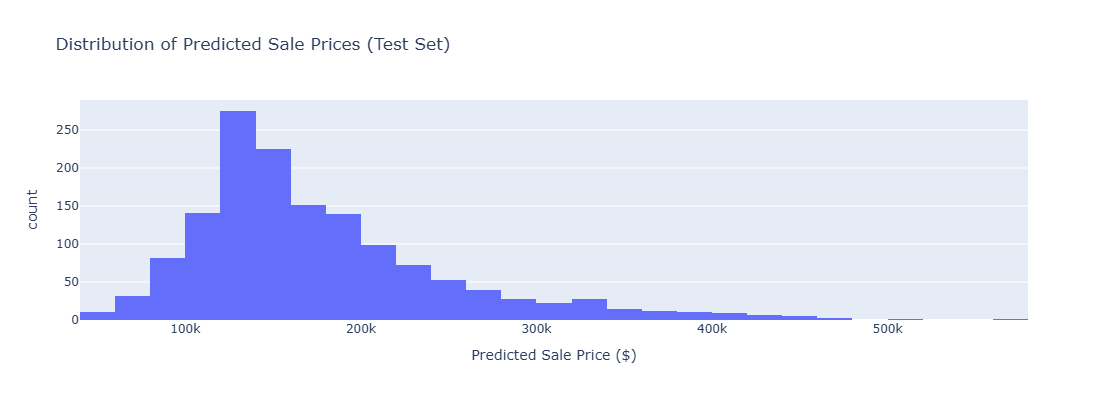


Predicted Price Statistics:
count      1459.000000
mean     176761.171875
std       74206.695312
min       49056.664062
25%      127790.808594
50%      156250.890625
75%      207533.328125
max      563739.687500
Name: SalePrice, dtype: float64


In [43]:
# Visualize the distribution of predicted prices
fig = px.histogram(
    submission,
    x='SalePrice',
    nbins=50,
    title='Distribution of Predicted Sale Prices (Test Set)',
    labels={'SalePrice': 'Predicted Sale Price ($)', 'count': 'Frequency'}
)

fig.update_layout(
    showlegend=False,
    height=400
)

fig.show()

print(f"\nPredicted Price Statistics:")
print(submission['SalePrice'].describe())

The submission came with a final score of 0.12521, which is in the ballpark as other verified and highly rated submissions for this competition.

## Project Summary

This project implemented a comprehensive machine learning pipeline to predict house sale prices for the Kaggle House Prices competition. The workflow consisted of several key stages:

### Data Preprocessing and Feature Engineering
- Analyzed missing data patterns and implemented appropriate imputation strategies:
  - Simple median/mode imputation for features with low missingness (<5%)
  - Neighborhood-based median imputation for LotFrontage to capture local housing characteristics
  - Categorical "Missing" indicators for basement and garage features to preserve information about houses without these amenities
  - Numeric 0 values for numerical basement/garage measurements (SF, area) when these features were absent
- Applied log transformation to the target variable (SalePrice) to normalize the right-skewed distribution
- Used ordinal encoding for categorical features with natural ordering (quality ratings, conditions)
- Applied one-hot encoding for nominal categorical features
- Standardized all numerical features to mean=0 and std=1

### Model Development and Hyperparameter Tuning
Three different model architectures were trained and compared:

**1. Random Forest Regressor**
- Performed exhaustive grid search over key hyperparameters:
  - n_estimators: [100, 200, 300]
  - max_depth: [10, 20, 30, None]
  - min_samples_split: [2, 5, 10]
  - min_samples_leaf: [1, 2, 4]
- Used 3-fold cross-validation to evaluate each parameter combination
- Best configuration achieved strong validation performance with good generalization

**2. XGBoost Regressor**
- Conducted comprehensive grid search across multiple hyperparameters:
  - n_estimators: [500, 1000, 1500]
  - learning_rate: [0.01, 0.05, 0.1]
  - max_depth: [3, 4, 5, 6]
  - min_child_weight: [1, 3, 5]
  - subsample: [0.7, 0.8, 0.9]
  - colsample_bytree: [0.7, 0.8, 0.9]
- This extensive search space resulted in the best-performing model
- XGBoost's gradient boosting approach proved most effective for this dataset

**3. Neural Network**
- Experimented with various architectures including different:
  - Number of hidden layers (ranging from 2 to 5 layers)
  - Hidden layer sizes (32, 64, 128, 256 neurons)
  - Activation functions (ReLU, tanh, leaky ReLU)
  - Dropout rates for regularization (0.2 to 0.4)
  - Learning rates and optimizers (Adam, RMSprop)
- Despite architectural experimentation, the neural network consistently underperformed compared to tree-based methods
- The limited dataset size (~1,460 training samples) proved insufficient for training deep neural networks effectively
- Neural networks typically require substantially larger datasets (tens of thousands of samples) to learn complex non-linear patterns and avoid overfitting

### Results
The XGBoost model with optimized hyperparameters achieved the best performance and was selected for final submission, yielding a Kaggle score of 0.12521. This demonstrates that for tabular data with limited sample size, well-tuned gradient boosting methods consistently outperform neural networks.